DMIPY VERDICT

In [2]:
from dmipy.signal_models import sphere_models, cylinder_models, gaussian_models

Setting up the VERDICT model

In [3]:
sphere = sphere_models.S4SphereGaussianPhaseApproximation(diffusion_constant=1.2e-9)
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()

from dmipy.core.modeling_framework import MultiCompartmentModel
verdict_mod = MultiCompartmentModel(models=[sphere, ball, stick])
verdict_mod.parameter_names

We highly recommend installing pathos to take advantage of multicore processing.


['S4SphereGaussianPhaseApproximation_1_diameter',
 'G1Ball_1_lambda_iso',
 'C1Stick_1_mu',
 'C1Stick_1_lambda_par',
 'partial_volume_0',
 'partial_volume_1',
 'partial_volume_2']

Printing the parameter cardinality to figure out the parameter names, and their input format.

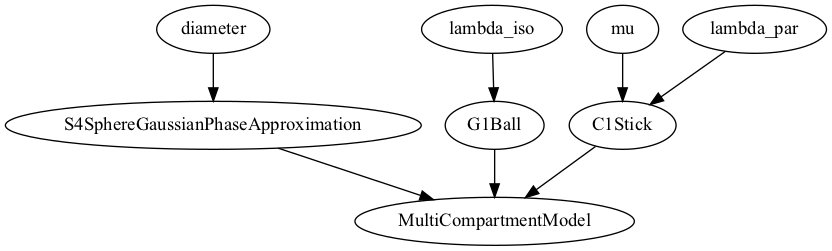

In [4]:
from IPython.display import Image
verdict_mod.visualize_model_setup(view=False, cleanup=False, with_parameters=True)
Image('Model Setup.png')

In [5]:
verdict_mod.set_fixed_parameter('G1Ball_1_lambda_iso', 2e-9)
verdict_mod.set_parameter_optimization_bounds('C1Stick_1_lambda_par', [3.05e-9, 10e-9])
verdict_mod.parameter_cardinality

OrderedDict([('S4SphereGaussianPhaseApproximation_1_diameter', 1),
             ('C1Stick_1_mu', 2),
             ('C1Stick_1_lambda_par', 1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1),
             ('partial_volume_2', 1)])

we align the Stick with some angle and give it a diffusivity of 1.7e-9 m^2/s. We obtain the right ordering for the input of the function by using the model's parameters_to_parameter_vector() function:

Setting up an acquisition scheme

In [8]:
from dmipy.core.acquisition_scheme import acquisition_scheme_from_schemefile
from os.path import join


acquisition_path_GS55 = "/Users/theavage/Documents/Master/Data/GS55 - long acquisition"

acquisition_path_GS35 = "/Users/theavage/Documents/Master/Data/GS35"

GS35 = "Verdict_brain_5shell_mag2.scheme"

scheme = acquisition_scheme_from_schemefile(join(acquisition_path_GS35, GS35))
scheme.print_acquisition_info

Acquisition scheme summary

total number of measurements: 20
number of b0 measurements: 5
number of DWI shells: 5

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |1         |0               |0                        |4.715999999999999|23.484    |50.0 
1           |3         |88              |50                       |4.715999999999999|23.484    |50.0 
2           |1         |0               |0                        |12.212     |31.272000000000002|65.0 
3           |3         |499             |41                       |12.212     |31.272000000000002|65.0 
4           |1         |0               |0                        |16.448     |32.072    |73.4 
5           |3         |2004            |62                       |16.448     |32.072    |73.4 
6           |1         |0               |0                        |24.764000000000003|43.736    |90.1 
7           |3         |3000            |43                       |24.76400000000

In [17]:
import dipy
data = dipy.data.fetcher.load_nifti_data(join(acquisition_path_GS35,"P35_dwi.nii.gz"))

test_voxel = data[90, 136, 176, :]

In [18]:
verdict_fit = verdict_mod.fit(scheme, test_voxel, solver='mix', use_parallel_processing=False)

Setup MIX optimizer in 0.0022127628326416016 seconds
Fitting of 1 voxels complete in 4.487776041030884 seconds.
Average of 4.487776041030884 seconds per voxel.


In [20]:
verdict_fit.fitted_parameters

{'S4SphereGaussianPhaseApproximation_1_diameter': array([2.e-05]),
 'C1Stick_1_mu': array([[2.05844107, 0.85233397]]),
 'C1Stick_1_lambda_par': array([3.05e-09]),
 'partial_volume_0': array([0.4839261]),
 'partial_volume_1': array([0.00516074]),
 'partial_volume_2': array([0.51091316])}

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.image as mpimg
img=mpimg.imread("http://camino.cs.ucl.ac.uk/uploads/Tutorials/VCLSsynth.png")
    
mask_nonzero = scheme.gradient_strengths>0.
G_nonzero = scheme.gradient_strengths[mask_nonzero]
Delta_nonzero = scheme.Delta[mask_nonzero]
delta_nonzero = scheme.delta[mask_nonzero]

predicted_data = verdict_fit.predict()[0]
predicted_data_nonzero = predicted_data[mask_nonzero]
data_nonzero = test_voxel[mask_nonzero]

fig, axs = plt.subplots(1, 2, figsize=[30, 10])
axs = axs.ravel()
axs[0].imshow(img)
axs[0].set_title('UCL Verdict Results', fontsize=30)
axs[0].axis('off')

for delta_, Delta_ in np.unique(np.c_[scheme.shell_delta, scheme.shell_Delta], axis=0):
    mask = np.all([Delta_nonzero == Delta_, delta_nonzero == delta_], axis=0)
    axs[1].plot(G_nonzero[mask], predicted_data_nonzero[mask])
    axs[1].scatter(G_nonzero[mask], data_nonzero[mask], s=3., marker='o')
axs[1].set_title('Dmipy Verdict Results', fontsize=30)
axs[1].set_xlabel('G(T/m)', fontsize=20)
axs[1].set_ylabel('S', fontsize=20);


(10, 10, 20)
(20,)


/var/folders/gd/mgk6_hls4dx8f77fjjb2b6980000gn/T/ipykernel_848/3659799666.py:5: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  img=mpimg.imread("http://camino.cs.ucl.ac.uk/uploads/Tutorials/VCLSsynth.png")


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 20